In [1]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hclust
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree, fcluster
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import euclidean_distances
import kmedoids
from scipy.cluster.vq import kmeans, vq

In [2]:
df_log = pd.read_csv("CGS_data/data/SRP073813/SRP073813_log.csv")
df_meta = pd.read_csv("CGS_data/data/SRP073813/SRP073813_meta.csv")

In [3]:
df_log.set_index("HUGO", inplace = True)
df_meta.set_index("ID", inplace = True) #Setting the index for data makes the enrichment analysis easier
df_meta = df_meta['refinebio_subject'] #removes unnecessary data 

In [4]:
df_meta = df_meta.to_frame()

In [5]:
df_log =round(df_log) 
df_log = df_log.T #swaps columns and indexes
df_log = df_log.join(df_meta)

In [6]:
df_log = df_log.loc[:, ~df_log.columns.duplicated()] #removes duplicate columns prevent deseq

In [7]:
#Transfomring the data to contain only data collected from a certain part of the brain in our patients 
df_log = df_log[df_log["refinebio_subject"].str.contains('nacc')]
df_meta = df_meta[df_meta["refinebio_subject"].str.contains('nacc')] 

In [8]:
df_log.drop("refinebio_subject",axis =1,inplace = True)

In [9]:
df_log = df_log.T

In [10]:
df_log

,SRR3438559,SRR3438560,SRR3438561,SRR3438562,SRR3438615,SRR3438616,SRR3438617,SRR3438618,SRR3438619,SRR3438620,...,SRR3438856,SRR3438863,SRR3438869,SRR3438891,SRR3438897,SRR3438899,SRR3438902,SRR3438903,SRR3438904,SRR3438905
TSPAN6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
TNMD,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DPM1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
SCYL3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
FIRRM,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NOTCH2NLC,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
ARMCX5-GPRASP2,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
LOC112268419,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
LOC124903324,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
#get variacne sort by it and select the top ones to do Hclust on
df_log["variance"] = np.var(df_log.values, axis=1)
df = df_log.sort_values("variance", ascending=False)
df.drop("variance", axis =1, inplace = True)
dfTen = df.head(10)
dfHun = df.head(100)
dfThous = df.head(1000)
dfTenThous = df.head(10000)
dfFiveThous = df.head(5000)


In [12]:
dfTen = dfTen.T
dfHun = dfHun.T
dfThous = dfThous.T
dfTenThous = dfTenThous.T
dfFiveThous = dfFiveThous.T

In [13]:
dfFiveThous

,CHI3L1,PENK,PTPN5,SYNDIG1L,XIST,HSPA1A,RAP1GAP,PEG3,MOBP,NRGN,...,KLHDC7B,ADAM20,SCFD1,MMP28,VLDLR,ENAM,LINC01980,ICE2,ZXDC,LL22NC03-63E9.3
SRR3438559,2.0,5.0,6.0,7.0,4.0,5.0,6.0,5.0,7.0,6.0,...,2.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0
SRR3438560,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,5.0,7.0,...,1.0,1.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0
SRR3438561,3.0,6.0,7.0,7.0,2.0,4.0,7.0,5.0,5.0,6.0,...,1.0,1.0,2.0,3.0,2.0,2.0,1.0,3.0,3.0,1.0
SRR3438562,3.0,6.0,7.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,...,2.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0
SRR3438615,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,4.0,7.0,...,2.0,1.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3438899,2.0,5.0,6.0,7.0,2.0,4.0,6.0,6.0,7.0,7.0,...,1.0,2.0,3.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0
SRR3438902,3.0,2.0,3.0,3.0,2.0,7.0,3.0,4.0,7.0,3.0,...,1.0,1.0,2.0,3.0,3.0,1.0,1.0,3.0,3.0,2.0
SRR3438903,3.0,3.0,5.0,6.0,2.0,4.0,6.0,6.0,6.0,6.0,...,1.0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0
SRR3438904,5.0,3.0,5.0,4.0,2.0,7.0,5.0,4.0,7.0,5.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0


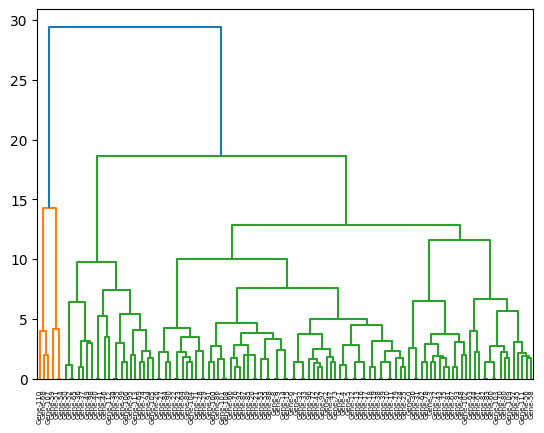

In [14]:
linkage_matrix = hclust.linkage(dfTen, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfTen.shape[0])])
plt.show()

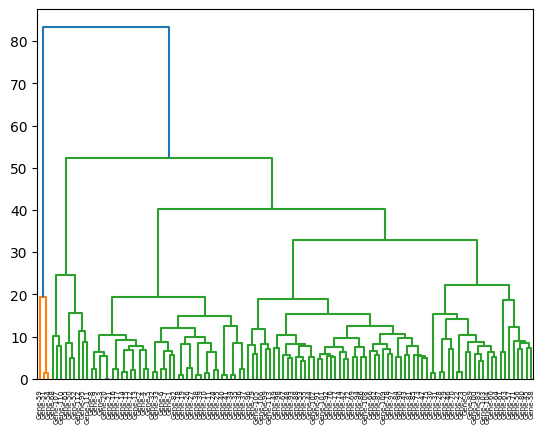

In [15]:
linkage_matrix = hclust.linkage(dfHun, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfHun.shape[0])])
plt.show()

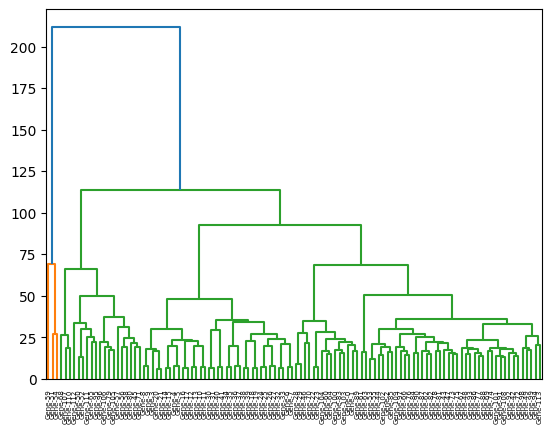

In [16]:
linkage_matrix = hclust.linkage(dfThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfThous.shape[0])])
plt.show()

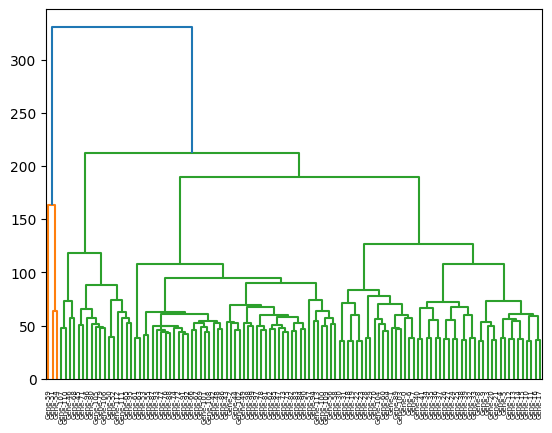

In [17]:
linkage_matrix = hclust.linkage(dfTenThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfTenThous.shape[0])])
plt.show()

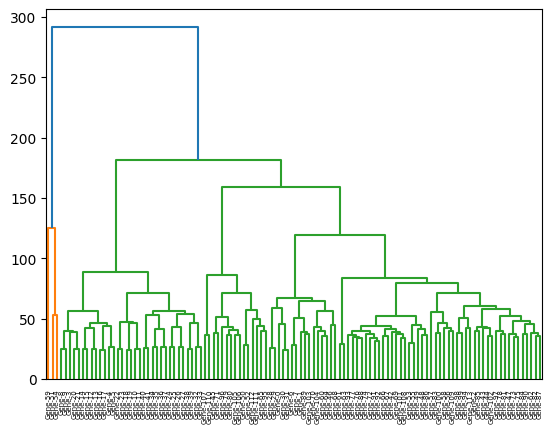

In [18]:
linkage_matrix = hclust.linkage(dfFiveThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfFiveThous.shape[0])])
plt.show()

In [19]:
dfFiveThous = dfFiveThous.apply(pd.to_numeric, errors='coerce')

In [20]:
dfFiveThous = dfFiveThous.dropna()

In [21]:
dfFiveThous

,CHI3L1,PENK,PTPN5,SYNDIG1L,XIST,HSPA1A,RAP1GAP,PEG3,MOBP,NRGN,...,KLHDC7B,ADAM20,SCFD1,MMP28,VLDLR,ENAM,LINC01980,ICE2,ZXDC,LL22NC03-63E9.3
SRR3438559,2.0,5.0,6.0,7.0,4.0,5.0,6.0,5.0,7.0,6.0,...,2.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0
SRR3438560,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,5.0,7.0,...,1.0,1.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0
SRR3438561,3.0,6.0,7.0,7.0,2.0,4.0,7.0,5.0,5.0,6.0,...,1.0,1.0,2.0,3.0,2.0,2.0,1.0,3.0,3.0,1.0
SRR3438562,3.0,6.0,7.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,...,2.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0
SRR3438615,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,4.0,7.0,...,2.0,1.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3438899,2.0,5.0,6.0,7.0,2.0,4.0,6.0,6.0,7.0,7.0,...,1.0,2.0,3.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0
SRR3438902,3.0,2.0,3.0,3.0,2.0,7.0,3.0,4.0,7.0,3.0,...,1.0,1.0,2.0,3.0,3.0,1.0,1.0,3.0,3.0,2.0
SRR3438903,3.0,3.0,5.0,6.0,2.0,4.0,6.0,6.0,6.0,6.0,...,1.0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0
SRR3438904,5.0,3.0,5.0,4.0,2.0,7.0,5.0,4.0,7.0,5.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0


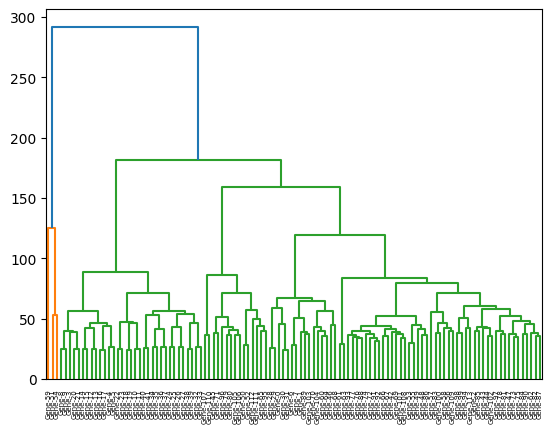

In [22]:
dend = hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfFiveThous.shape[0])])

In [23]:
#Transform data for R-stuido to create SANKEY PLOT

# Define the number of clusters
num_clusters = 4

# Define a function to perform hierarchical clustering and return cluster memberships
def hierarchical_clustering(data, num_clusters, method='ward'):
    # Calculate the distance matrix
    distance_matrix = pdist(data.T, 'euclidean')
        # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # Cut the dendrogram to get cluster labels
    cluster_labels = cut_tree(linkage_matrix, n_clusters=num_clusters).flatten()
    
    return cluster_labels

In [24]:
# Define subsets for clustering
gene_subsets = [10, 100, 1000, 10000]
data = df
# Store results
results = {}

for subset in gene_subsets:
    top_genes = data.var(axis=1).nlargest(subset)
    data_subset = data.loc[top_genes.index]
    
    # Get cluster memberships for the subset
    cluster_labels = hierarchical_clustering(data_subset, num_clusters)
    
    results[f"X{subset}"] = cluster_labels

In [25]:
np.bincount(results["X10000"])

array([47, 47, 17,  3], dtype=int64)

In [26]:
dissDfTen = euclidean_distances(dfTen)
dissDfHun = euclidean_distances(dfHun)
dissDfThous = euclidean_distances(dfThous)
dissDfTenThous = euclidean_distances(dfTenThous)
dissDfFiveThous = euclidean_distances(dfFiveThous)

In [27]:
# clustering using PAM on ten genes
tenPamk4 = kmedoids.pam(dissDfTen, medoids = 4, max_iter = 100, init = "first", random_state = None) 


In [28]:
tenPamk4

KMedoidsResult(loss=271.39245512067566, labels=[0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 3 3 3
 1 1 1 0 0 1 1 1 0 0 1 0 3 3 2 3 1 2 1 0 0 0 2 0 0 0 0 0 3 1 1 0 0 0 0 1 1
 3 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 3 1 1 3 3 0 1 0 0 0 0 3 0 1 0 2
 0 3 3], medoids=[ 60  47  51 113], n_iter=5, n_swaps=4)

In [29]:
#clustering using PAM on one hundred genes
hunPamk4 = kmedoids.pam(dissDfHun, medoids = 4, max_iter = 100, init = "first", random_state = None) 

In [30]:
hunPamk4

KMedoidsResult(loss=804.5763558200044, labels=[0 0 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 3 3 3 0 0 3 3 3 0 2 0 3 2 3 0 0 0 2 0 0 3 3 0 0 3 3 0 0 0 0 3 3
 3 3 3 3 3 0 0 3 3 0 0 3 3 3 3 0 3 3 3 3 0 0 3 3 3 3 0 3 3 0 0 0 0 0 3 0 0
 0 0 0], medoids=[103  24  54  77], n_iter=6, n_swaps=5)

In [31]:
#clustering using PAM on one thousand genes
thousPamk4 = kmedoids.pam(dissDfThous, medoids = 4, max_iter = 100, init = "first", random_state = None) 

In [32]:
thousPamk4

KMedoidsResult(loss=2198.6550842318156, labels=[0 0 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 3 3 3 0 0 3 3 3 0 2 0 3 2 3 0 0 0 2 0 0 3 3 0 0 3 3 0 0 0 0 3 3
 3 3 3 3 3 0 0 0 0 0 3 3 3 3 3 0 3 3 3 3 0 0 0 3 3 3 0 3 3 0 0 0 0 0 3 0 0
 0 0 0], medoids=[83 24 54 77], n_iter=6, n_swaps=5)

In [33]:
#clustering using PAM on ten thousand genes
tenThousPamk4 = kmedoids.pam(dissDfTenThous, medoids = 4, max_iter = 100, init = "first", random_state = None) 


In [34]:
tenThousPamk4

KMedoidsResult(loss=5908.939623649717, labels=[1 1 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 1 1 3 3 3 3 3 3 3
 3 3 3 3 3 1 1 1 2 1 1 1 1 2 0 2 1 0 1 1 2 1 0 1 1 1 1 1 2 1 1 1 1 1 2 1 1
 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 1 1 2
 2 2 1], medoids=[51 82 71 12], n_iter=5, n_swaps=4)

In [35]:
#clustering using PAM on five thousand genes
fiveThousPamk4 = kmedoids.pam(dissDfFiveThous, medoids = 4, max_iter = 100, init = "first", random_state = None) 


In [36]:
fiveThousPamk4

KMedoidsResult(loss=4621.892078813149, labels=[3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 0 3 3 3 3 3 3 3
 3 3 3 3 3 2 3 3 0 0 2 2 2 0 1 0 2 1 2 0 2 2 1 2 2 2 2 2 0 2 2 0 2 2 0 2 2
 2 2 2 2 2 0 0 2 2 2 2 3 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 0 0 0 2 2 0
 0 0 2], medoids=[71 51 91 12], n_iter=6, n_swaps=5)

In [37]:
centroids, labels = kmeans(dfTen, 3)

In [38]:
centroids

array([[4.68965517, 4.5862069 , 5.48275862, 5.82758621, 2.68965517,
        5.20689655, 6.        , 5.20689655, 5.86206897, 6.10344828],
       [2.56097561, 5.8902439 , 6.47560976, 6.68292683, 2.43902439,
        4.73170732, 6.57317073, 5.75609756, 5.40243902, 6.59756098],
       [1.66666667, 1.66666667, 1.66666667, 1.66666667, 1.66666667,
        1.66666667, 1.66666667, 1.66666667, 2.66666667, 1.66666667]])

In [39]:
labels

2.3980120100847517

In [100]:
alluval_data = dfTen.index.to_frame()

In [105]:
alluval_data["X10"] =  tenPamk4.labels
alluval_data["X100"] = hunPamk4.labels
alluval_data["X1000"] = thousPamk4.labels
alluval_data["X10000"] = tenThousPamk4.labels

In [110]:
alluval_data.drop(0, axis = 1, inplace=  True)

In [111]:
alluval_data.to_csv("CGS_Data/data/SRP073813/Sankey_plot_dan.csv")

In [40]:
assignments, distance = vq(dfTen, centroids)

In [41]:
assignments

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0])

In [42]:
distance

array([2.78425611, 1.43845586, 1.60665814, 2.07679024, 1.96825641,
       1.96825641, 1.57600425, 1.57600425, 1.87951321, 1.87951321,
       1.93072314, 1.93072314, 1.96825641, 1.96825641, 2.24061928,
       2.24061928, 2.00508722, 2.00508722, 1.60665814, 2.11172895,
       1.84678604, 1.84678604, 1.96825641, 1.96825641, 1.41279317,
       1.36895336, 1.91168018, 1.91168018, 3.05971211, 3.05971211,
       3.71166706, 3.71166706, 1.63673802, 1.63673802, 3.22446061,
       3.22446061, 3.30369303, 3.59845389, 1.48023866, 1.48023866,
       2.60316281, 2.60316281, 1.49662519, 2.93355427, 2.35214156,
       2.85583034, 2.30828524, 1.18769469, 3.18087028, 3.4417179 ,
       3.90188832, 1.20185043, 3.79889839, 1.88599049, 1.20185043,
       2.39325967, 2.84978669, 4.32920014, 2.62952232, 2.40370085,
       1.57600425, 3.17703407, 2.1289833 , 4.78777754, 1.89887878,
       3.79889839, 2.01116012, 2.73119006, 4.24067838, 2.05316749,
       3.02014638, 3.25664561, 1.52087399, 1.62927012, 2.40342

In [43]:
dfTen.keys()

Index(['CHI3L1', 'PENK', 'PTPN5', 'SYNDIG1L', 'XIST', 'HSPA1A', 'RAP1GAP',
       'PEG3', 'MOBP', 'NRGN'],
      dtype='object')

In [44]:
centroids, labels = kmeans(dfTen, 4)

In [45]:
assignments, distance = vq(dfTen, centroids)

In [46]:
def get_clusters(data, k):
    centroids, labels = kmeans(data, k)
    assignments, distance = vq(data, centroids)
    return {"centroids":centroids, "assignments":assignments, "distance":distance}

In [47]:
kmeans4_5000 = get_clusters(dfFiveThous, 4)

In [48]:
def plot_k(data, start, stop, name):
    xval = []
    yval = []
    for n in range(start,stop):
        xval.append(n)
        kmeansx_y = get_clusters(data, n)
        yval.append(np.mean(kmeansx_y['distance']))
    plt.plot(xval,yval,marker='x')
    plt.xlabel('Number of clusters')
    plt.ylabel('Avg distance to cluster')
    plt.title('Cost of k clusters for ' + name + ' genes')
    plt.show()
        

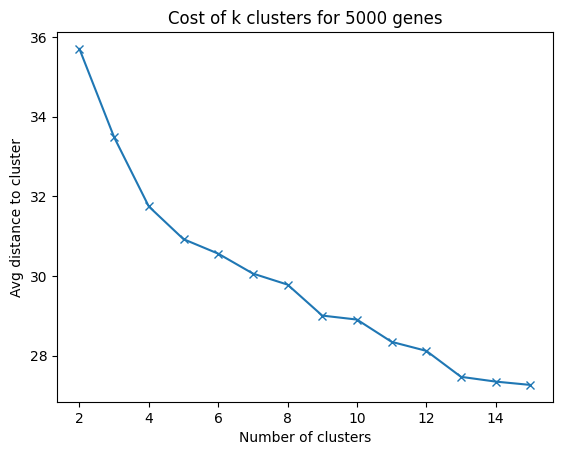

In [49]:
plot_k(dfFiveThous,2,16,'5000')

In [58]:
kmeans4_5000["assignments"]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 3, 3, 1, 1, 1, 3, 0, 3, 1, 0, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1,
       3, 3, 3, 3])

In [50]:
# Convert results to DataFrame and save to CSV
df = pd.DataFrame(results)
df['Sample'] = data.columns
df.to_csv("CGS_Data/data/SRP073813/Sankey_plot.csv", index=False)

In [52]:
dfFiveThous = dfFiveThous.join(df_meta, how = "inner")
dfFiveThous 

,CHI3L1,PENK,PTPN5,SYNDIG1L,XIST,HSPA1A,RAP1GAP,PEG3,MOBP,NRGN,...,ADAM20,SCFD1,MMP28,VLDLR,ENAM,LINC01980,ICE2,ZXDC,LL22NC03-63E9.3,refinebio_subject
SRR3438559,2.0,5.0,6.0,7.0,4.0,5.0,6.0,5.0,7.0,6.0,...,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,nacc_schizophrenia
SRR3438560,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,5.0,7.0,...,1.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,nacc_control
SRR3438561,3.0,6.0,7.0,7.0,2.0,4.0,7.0,5.0,5.0,6.0,...,1.0,2.0,3.0,2.0,2.0,1.0,3.0,3.0,1.0,nacc_control
SRR3438562,3.0,6.0,7.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,...,1.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,nacc_schizophrenia
SRR3438615,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,4.0,7.0,...,1.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.0,nacc_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3438899,2.0,5.0,6.0,7.0,2.0,4.0,6.0,6.0,7.0,7.0,...,2.0,3.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0,nacc_major depression
SRR3438902,3.0,2.0,3.0,3.0,2.0,7.0,3.0,4.0,7.0,3.0,...,1.0,2.0,3.0,3.0,1.0,1.0,3.0,3.0,2.0,nacc_schizophrenia
SRR3438903,3.0,3.0,5.0,6.0,2.0,4.0,6.0,6.0,6.0,6.0,...,2.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,nacc_schizophrenia
SRR3438904,5.0,3.0,5.0,4.0,2.0,7.0,5.0,4.0,7.0,5.0,...,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,nacc_schizophrenia


In [112]:
clusters_samples = cut_tree(linkage_matrix, 4).flatten()
dfFiveThous["hclust"] = clusters_samples
dfFiveThous["PAM"] = fiveThousPamk4.labels
dfFiveThous["kmeans"] = kmeans4_5000["assignments"]
# Assign cluster labels to samples
unique_groups = ["hclust", "PAM", "kmeans"]
# Perform pairwise Chi-squared tests for each group against cluster labels
chi2_results= []
for group1 in unique_groups:
    for group2 in unique_groups:
        if(group1 == group2):
            continue
        test = f'{group1}' ' vs ' f'{group2}'
        contingency_table = pd.crosstab(dfFiveThous[group1], dfFiveThous[group2])
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table)
        chi2_results.append({
            "Comparison": test,
            "Test Statistic (Chi2)": chi2_stat,
            "Adj. p-value": p_val,
            "Degrees of Freedom": dof
        })


# Convert results to a DataFrame
chi2_results = pd.DataFrame(chi2_results)

chi2_results

,Comparison,Test Statistic (Chi2),Adj. p-value,Degrees of Freedom
0,hclust vs PAM,269.489796,7.586235e-53,9
1,hclust vs kmeans,251.647387,4.478581e-49,9
2,PAM vs hclust,269.489796,7.586235e-53,9
3,PAM vs kmeans,295.342448,2.537691e-58,9
4,kmeans vs hclust,251.647387,4.478581e-49,9
5,kmeans vs PAM,295.342448,2.537691e-58,9


In [86]:
heatmap_data = dfFiveThous[["PAM", "kmeans", "hclust"]]

In [91]:
heatmap_data =heatmap_data.join(df_meta, how = 'inner')


In [93]:
heatmap_data.set_index("refinebio_subject", inplace = True)

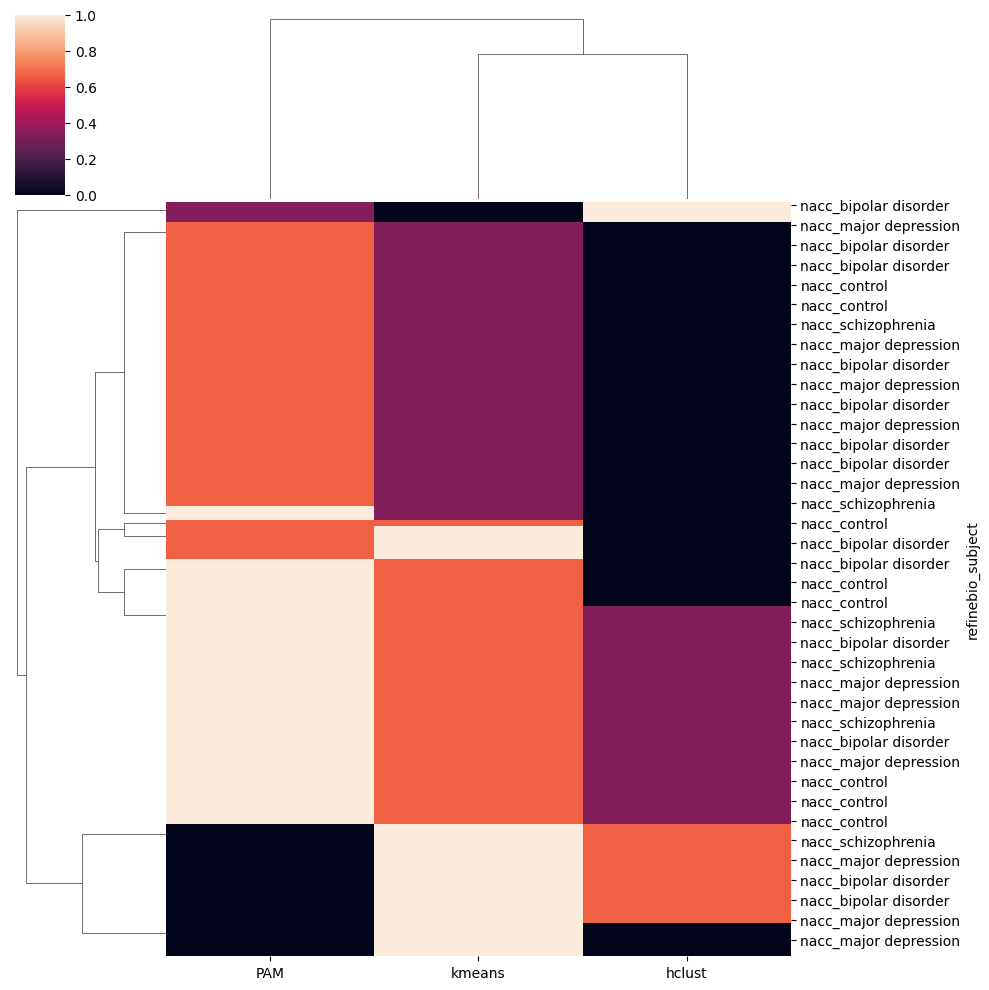

In [95]:
sns.clustermap(heatmap_data, metric="euclidean", standard_scale=1)
plt.show()